In [1]:


import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ,execute
from qiskit.tools.monitor import job_monitor

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')
manila = provider.get_backend('ibmq_manila')
santiago = provider.get_backend('ibmq_santiago')

qiskit.__qiskit_version__

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'qiskit-terra': '0.20.0', 'qiskit-aer': '0.10.3', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': None, 'qiskit': '0.35.0', 'qiskit-nature': '0.3.2', 'qiskit-finance': '0.3.1', 'qiskit-optimization': '0.3.2', 'qiskit-machine-learning': '0.4.0'}

# For Three Qubits
We create state that
$|\psi\rangle = \frac{1}{\sqrt{2}} (|000\rangle +i|111\rangle)
$


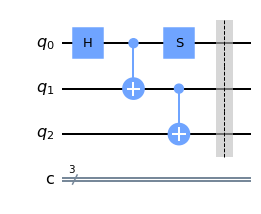

In [2]:
#create state 1/sqrt(2)*(|000>+i|111>)
q1 = QuantumRegister(3,'q')
c1 = ClassicalRegister(3,'c')
circuit1 = QuantumCircuit(q1, c1)
circuit1.h(q1[0])

circuit1.cx(q1[0],q1[1])

circuit1.cx(q1[1],q1[2])

circuit1.s(q1[0])
circuit1.barrier()
circuit1.draw(output='mpl')


# For Four Qubits
We create state that
$|\psi\rangle = \frac{1}{\sqrt{2}} (|0000\rangle +i|1111\rangle)
$

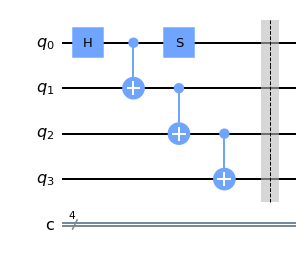

In [3]:
q2 = QuantumRegister(4, 'q')
c2 = ClassicalRegister(4, 'c')
circuit2 = QuantumCircuit(q2, c2)
circuit2.h(q2[0])
circuit2.cx(q2[0], q2[1])
circuit2.cx(q2[1], q2[2])
circuit2.cx(q2[2], q2[3])

circuit2.s(q2[0])
circuit2.barrier()
circuit2.draw(output='mpl')

# For Five Qubits
We create state that
$|\psi\rangle = \frac{1}{\sqrt{2}} (|00000\rangle +i|11111\rangle)
$

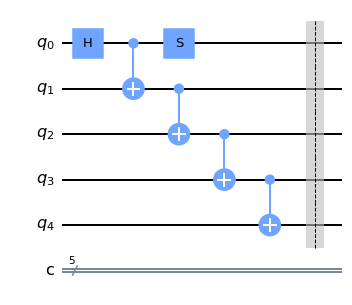

In [4]:
q3 = QuantumRegister(5, 'q')
c3 = ClassicalRegister(5, 'c')
circuit3 = QuantumCircuit(q3, c3)
circuit3.h(q3[0])
circuit3.cx(q3[0], q3[1])
circuit3.cx(q3[1], q3[2])
circuit3.cx(q3[2], q3[3])
circuit3.cx(q3[3], q3[4])
circuit3.s(q3[0])
circuit3.barrier()
circuit3.draw(output='mpl')

In [5]:
import qiskit.quantum_info as qi
stv1 = qi.Statevector.from_instruction(circuit1)
stv2 = qi.Statevector.from_instruction(circuit2)
stv3 = qi.Statevector.from_instruction(circuit3)
sim = Aer.get_backend('aer_simulator')
options = {'method': 'statevector'}
execute(circuit1, sim, backend_options=options)
execute(circuit3, sim, backend_options=options)
execute(circuit2, sim, backend_options=options)

In [6]:
stv1.draw('latex', prefix='Statevector1:')

<IPython.core.display.Latex object>

In [7]:
stv2.draw('latex', prefix='Statevector2:')

<IPython.core.display.Latex object>

In [8]:
stv3.draw('latex', prefix='Statevector3:')

<IPython.core.display.Latex object>

In [9]:
def measure_state(name,q,c,circuit):
    measurename = QuantumCircuit(q,c)
    state = 0
    for i in name:
        if i == 'X':
            measurename.h(q[state])
        elif i == 'Y':
            measurename.sdg(q[state])
            measurename.h(q[state])
        elif i == 'A':
            measurename.tdg(q[state])
            measurename.h(q[state])
        elif i == 'B':
            measurename.t(q[state])
            measurename.h(q[state])

        state += 1
    for i in range(state):
        measurename.measure(q[i],c[i])

    circuitname = circuit+measurename
    return circuitname


In [10]:
from itertools import product

def operator(x, y,qubit):

    oper = {'X':x,'Y':y}
    arr = list(product(oper,repeat=qubit))
    arr2 = list(product([oper['X'],oper['Y']],repeat=qubit))
    result = {}
    for i in range(len(arr)):
        sum = ''
        prod = 1
        for j in range(len(arr[i])):
            sum += arr[i][j]
            prod *= arr2[i][j]
        result[sum] = prod
    return result

def mermin_circuits(circuit,qubit):
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    a = operator(1, 1j,qubit)
    b = operator(1, -1j,qubit)
    cir = []
    cir_name=[]
    coef = []
    for i in a:
        if(a[i] != b[i]):
            locals()['circuit%s' % i] = measure_state(i,q,c,circuit)
            cir.append(locals()['circuit%s' % i])
            cir_name.append('circuit'+i)
            coef.append(a[i].imag )
    return cir,cir_name,coef


In [11]:

def ardehali_circuits(circuit,qubit):
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    im_th = {'A':1,'B':1}
    re_th = {'A':1,'B':-1}
    a = operator(1, 1j,qubit-1)
    new_a={}
    new_b={}
    for i in a:
        for j in re_th:
            temp = i
            new_a[temp+j] = re_th[j]*a[i]


    for i in a:
        for j in im_th:
            temp = i
            new_b[temp+j] = im_th[j]*a[i]

    cir = []
    cir_name=[]
    coef = []
    for i in new_a:
        if(new_a[i].real != 0):

            locals()['circuit%s' % i] = measure_state(i,q,c,circuit)
            cir.append(locals()['circuit%s' % i])
            cir_name.append('circuit'+i)
            coef.append(int(new_a[i].real))
    for i in new_b:
        if(new_b[i].imag != 0):
            locals()['circuit%s' % i] = measure_state(i,q,c,circuit)
            cir.append(locals()['circuit%s' % i])
            cir_name.append('circuit'+i)
            coef.append(int(new_b[i].imag))
    return cir,cir_name,coef


In [12]:
############################3-QUBIT CIRCUİTS###############################
states_three = ['000','001','010','011','100','101','110','111']
mermin1,mermin1_name,mermin_coeff1 = mermin_circuits(circuit1,3)
ardehali1,ardehali1_name,ardehali_coeff1 = ardehali_circuits(circuit1,3)

############################4-QUBIT CIRCUİTS###############################
states_four = ['0000','0001','0010','0011','0100','0101','0110','0111','1000','1001','1010','1011','1100','1101','1110','1111',]
mermin2,mermin2_name,mermin_coeff2 = mermin_circuits(circuit2,4)
ardehali2,ardehali2_name,ardehali_coeff2 = ardehali_circuits(circuit2,4)

############################5-QUBIT CIRCUİTS###############################
states_five = ['00000','00001','00010','00011','00100','00101','00110','00111','01000','01001','01010','01011','01100','01101','01110','01111','10000','10001','10010','10011','10100','10101','10110','10111','11000','11001','11010','11011','11100','11101','11110','11111']
mermin3,mermin3_name,mermin_coeff3 = mermin_circuits(circuit3,5)
ardehali3,ardehali3_name,ardehali_coeff3 = ardehali_circuits(circuit3,5)

/tmp/ipykernel_107/2043140286.py:21: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuitname = circuit+measurename


['circuitXXY', 'circuitXYX', 'circuitYXX', 'circuitYYY']


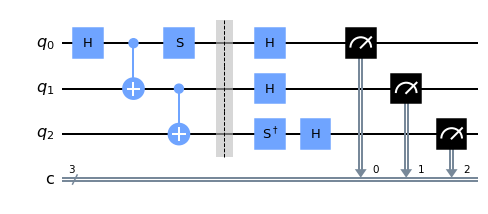

In [13]:
print(mermin1_name)
mermin1[0].draw(output='mpl')

['circuitXXXY', 'circuitXXYX', 'circuitXYXX', 'circuitXYYY', 'circuitYXXX', 'circuitYXYY', 'circuitYYXY', 'circuitYYYX']
[1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0]


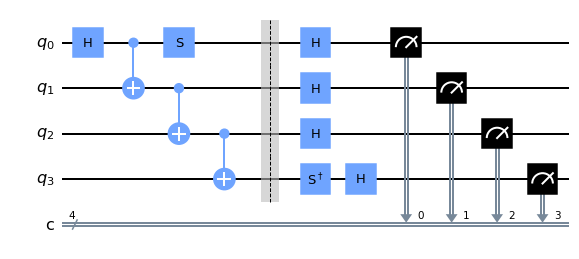

In [14]:
print(mermin2_name)
print(mermin_coeff2)
mermin2[0].draw(output='mpl')

['circuitXXXXY', 'circuitXXXYX', 'circuitXXYXX', 'circuitXXYYY', 'circuitXYXXX', 'circuitXYXYY', 'circuitXYYXY', 'circuitXYYYX', 'circuitYXXXX', 'circuitYXXYY', 'circuitYXYXY', 'circuitYXYYX', 'circuitYYXXY', 'circuitYYXYX', 'circuitYYYXX', 'circuitYYYYY']


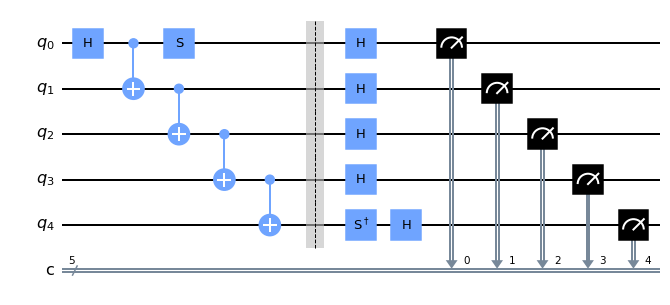

In [15]:
print(mermin3_name)
mermin3[0].draw(output='mpl')

['circuitXXA', 'circuitXXB', 'circuitYYA', 'circuitYYB', 'circuitXYA', 'circuitXYB', 'circuitYXA', 'circuitYXB']
[1, -1, -1, 1, 1, 1, 1, 1]


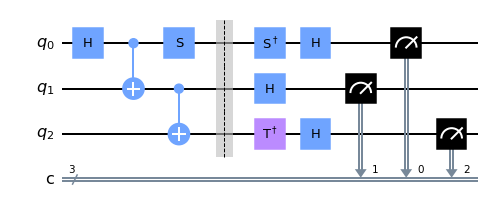

In [16]:
print(ardehali1_name)
print(ardehali_coeff1)
ardehali1[6].draw(output='mpl')

['circuitXXXA', 'circuitXXXB', 'circuitXYYA', 'circuitXYYB', 'circuitYXYA', 'circuitYXYB', 'circuitYYXA', 'circuitYYXB', 'circuitXXYA', 'circuitXXYB', 'circuitXYXA', 'circuitXYXB', 'circuitYXXA', 'circuitYXXB', 'circuitYYYA', 'circuitYYYB']


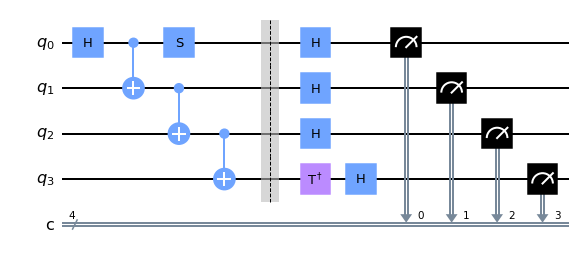

In [17]:
print(ardehali2_name)
ardehali2[0].draw(output='mpl')

['circuitXXXXA', 'circuitXXXXB', 'circuitXXYYA', 'circuitXXYYB', 'circuitXYXYA', 'circuitXYXYB', 'circuitXYYXA', 'circuitXYYXB', 'circuitYXXYA', 'circuitYXXYB', 'circuitYXYXA', 'circuitYXYXB', 'circuitYYXXA', 'circuitYYXXB', 'circuitYYYYA', 'circuitYYYYB', 'circuitXXXYA', 'circuitXXXYB', 'circuitXXYXA', 'circuitXXYXB', 'circuitXYXXA', 'circuitXYXXB', 'circuitXYYYA', 'circuitXYYYB', 'circuitYXXXA', 'circuitYXXXB', 'circuitYXYYA', 'circuitYXYYB', 'circuitYYXYA', 'circuitYYXYB', 'circuitYYYXA', 'circuitYYYXB']


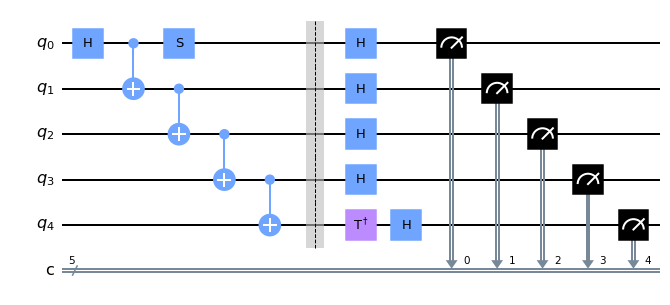

In [18]:
print(ardehali3_name)
ardehali3[0].draw(output='mpl')

In [19]:
def device_run(device,shots,circuits):
    transpiled_circuits = transpile(circuits, device)
    job_real = device.run(transpiled_circuits, shots=shots)
    job_monitor(job_real)
    result_real = job_real.result()

    counts = []
    for i in circuits:
        counts.append(result_real.get_counts(i))
    return counts


In [20]:
def ideal_run(circuits,shots):
    sim = Aer.get_backend('aer_simulator')
    result_ideal = sim.run(circuits,shots=shots).result()
    ideal_counts=[]
    for i in circuits:
        ideal_counts.append(result_ideal.get_counts(i))
    return ideal_counts



In [21]:
def expectation(counts,shots,states,coeff):
    Exp=[]
    for i in range(len(counts)):
        probs = 0
        for output in states:
            num = sum(int(i) for i in output)
            if output in counts[i]:
                if(num % 2 == 0):
                    probs += counts[i][output]/shots
                else:
                    probs -= counts[i][output]/shots
            else:
                probs += 0
        Exp.append(coeff[i]*probs)
    return sum(Exp)



In [22]:
shots=16384
m_ideal1 = ideal_run(mermin1,shots)
mermin_exp1 = expectation(m_ideal1,shots,states_three,mermin_coeff1)
m_ideal2 = ideal_run(mermin2,shots)
mermin_exp2 = expectation(m_ideal2,shots,states_four,mermin_coeff2)
m_ideal3 = ideal_run(mermin3,shots)
mermin_exp3 = expectation(m_ideal3,shots,states_five,mermin_coeff3)
print('MERMIN ideal expectation value for three qubits ',mermin_exp1)
print('MERMIN ideal expectation value for four qubits ',mermin_exp2)
print('MERMIN ideal expectation value for five qubits ',mermin_exp3)

MERMIN ideal expectation value for three qubits  4.0
MERMIN ideal expectation value for four qubits  8.0
MERMIN ideal expectation value for five qubits  16.0


In [23]:
shots=16384
a_ideal1 = ideal_run(ardehali1,shots)
ardehali_exp1 = expectation(a_ideal1,shots,states_three,ardehali_coeff1)
a_ideal2 = ideal_run(ardehali2,shots)
ardehali_exp2 = expectation(a_ideal2,shots,states_four,ardehali_coeff2)
a_ideal3 = ideal_run(ardehali3,shots)
ardehali_exp3 = expectation(a_ideal3,shots,states_five,ardehali_coeff3)
print('ARDEHALI ideal expectation value for three qubits ',ardehali_exp1)
print('ARDEHALI ideal expectation value for four qubits ',ardehali_exp2)
print('ARDEHALI ideal expectation value for five qubits ',ardehali_exp3)

ARDEHALI ideal expectation value for three qubits  5.6611328125
ARDEHALI ideal expectation value for four qubits  11.2696533203125
ARDEHALI ideal expectation value for five qubits  22.552734375


## FOR MANILA

In [24]:
shots=16384
circuit_arr = [mermin1,mermin2,mermin3]
state_arr =  [states_three,states_four,states_five]
coeff_arr = [mermin_coeff1,mermin_coeff2,mermin_coeff3]
"""
m_real1= device_run(manila,shots,mermin1)
m_exp1 = expectation(m_real1,shots,states_three,mermin_coeff1)
m_real2 = device_run(manila,shots2,mermin2)
m_exp2 = expectation(m_real2,shots2,states_four,mermin_coeff2)
m_real3 = device_run(manila,shots2,mermin3)
m_exp3 = expectation(m_real3,shots2,states_five,mermin_coeff3)
"""
real_arr = []
for i in circuit_arr:
    temp = []
    for j in range(10):
        real = device_run(manila,shots,i)
        temp.append(real)
    real_arr.append(temp)
exp_arr1 = []
for i in range(len(circuit_arr)):
    temp = []
    for j in (real_arr[i]):
        exp = expectation(j,shots,state_arr[i],coeff_arr[i])
        temp.append(exp)
    exp_arr1.append(temp)
print(exp_arr1)


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is queued (None)  

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


[[3.2728271484375, 3.29931640625, 3.3548583984375, 3.35546875, 3.3404541015625, 3.32373046875, 3.2685546875, 3.3414306640625, 3.31982421875, 3.3153076171875], [5.471923828125, 5.3638916015625, 5.5423583984375, 5.5064697265625, 5.5272216796875, 5.5458984375, 5.657470703125, 5.6220703125, 5.641357421875, 5.62255859375], [8.448486328125, 8.6671142578125, 8.9002685546875, 8.760498046875, 8.7939453125, 8.4219970703125, 8.2132568359375, 8.4815673828125, 8.23779296875, 7.9434814453125]]


In [25]:
import numpy as np
error_3 = np.std(exp_arr1[0], ddof=1) / np.sqrt(np.size(exp_arr1[0]))
print("3-qubit Error: ",error_3)
error_4 = np.std(exp_arr1[1], ddof=1) / np.sqrt(np.size(exp_arr1[1]))
print("4-qubit Error: ",error_4)
error_5 = np.std(exp_arr1[2], ddof=1) / np.sqrt(np.size(exp_arr1[2]))
print("5-qubit Error: ",error_5)

3-qubit Error:  0.009820437570559604
4-qubit Error:  0.028592158807743743
5-qubit Error:  0.09489400390804535


In [26]:
shots=16384
"""
a_real1= device_run(manila,shots,ardehali1)
a_exp1 = expectation(a_real1,shots,states_three,ardehali_coeff1)
a_real2 = device_run(manila,shots,ardehali2)
a_exp2 = expectation(a_real2,shots,states_four,ardehali_coeff2)
a_real3 = device_run(manila,shots,ardehali3)
a_exp3 = expectation(a_real3,shots,states_five,ardehali_coeff3)
"""
circuit_arr = [ardehali1,ardehali2,ardehali3]
state_arr =  [states_three,states_four,states_five]
coeff_arr = [ardehali_coeff1,ardehali_coeff2,ardehali_coeff3]
real_arr = []
for i in circuit_arr:
    temp = []
    for j in range(10):
        real = device_run(manila,shots,i)
        temp.append(real)
    real_arr.append(temp)
exp_arr2 = []
for i in range(len(circuit_arr)):
    temp = []
    for j in (real_arr[i]):
        exp = expectation(j,shots,state_arr[i],coeff_arr[i])
        temp.append(exp)
    exp_arr2.append(temp)
print(exp_arr2)


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (None)  

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


[[4.6578369140625, 4.683349609375, 4.640869140625, 4.664306640625, 4.712158203125, 4.6328125, 4.592041015625, 4.6201171875, 4.63720703125, 4.623291015625], [7.5594482421875, 7.6544189453125, 7.802978515625, 7.7569580078125, 7.89453125, 7.873291015625, 7.71484375, 7.734619140625, 7.700927734375, 7.722412109375], [11.0234375, 11.1649169921875, 11.5888671875, 11.881103515625, 12.184326171875, 12.4088134765625, 11.57080078125, 11.544921875, 10.833740234375, 10.987548828125]]


In [27]:
import numpy as np
error_3 = np.std(exp_arr2[0], ddof=1) / np.sqrt(np.size(exp_arr2[0]))
print("3-qubit Error: ",error_3)
error_4 = np.std(exp_arr2[1], ddof=1) / np.sqrt(np.size(exp_arr2[1]))
print("4-qubit Error: ",error_4)
error_5 = np.std(exp_arr2[2], ddof=1) / np.sqrt(np.size(exp_arr2[2]))
print("5-qubit Error: ",error_5)

3-qubit Error:  0.010862932636340502
4-qubit Error:  0.031322741353751966
5-qubit Error:  0.16655865208942705


## For Quito

In [28]:
shots=16384
circuit_arr = [mermin1,mermin2,mermin3]
state_arr =  [states_three,states_four,states_five]
coeff_arr = [mermin_coeff1,mermin_coeff2,mermin_coeff3]
"""
m_real1= device_run(manila,shots,mermin1)
m_exp1 = expectation(m_real1,shots,states_three,mermin_coeff1)
m_real2 = device_run(manila,shots2,mermin2)
m_exp2 = expectation(m_real2,shots2,states_four,mermin_coeff2)
m_real3 = device_run(manila,shots2,mermin3)
m_exp3 = expectation(m_real3,shots2,states_five,mermin_coeff3)
"""
real_arr = []
for i in circuit_arr:
    temp = []
    for j in range(10):
        real = device_run(quito,shots,i)
        temp.append(real)
    real_arr.append(temp)
exp_arr1 = []
for i in range(len(circuit_arr)):
    temp = []
    for j in (real_arr[i]):
        exp = expectation(j,shots,state_arr[i],coeff_arr[i])
        temp.append(exp)
    exp_arr1.append(temp)
print(exp_arr1)


Job Status: job is being validated

Job Status: job is queued (13)    

Job Status: job is queued (12)    

Job Status: job is queued (11)    

Job Status: job is queued (10)    

Job Status: job is queued (8)     

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (13)    

Job Status: job is queued (12)    

Job Status: job is queued (11)    

Job Status: job is queued (9)     

Job Status: job is queued (8)     

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (42)    

Job Status: job is queued (16)    

Job Status: job is queued (15)    

Job Status: job is queued (12)    

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (41)    

Job Status: job is queued (15)    

Job Status: job is queued (14)    

Job Status: job is queued (13)    

Job Status: job is queued (12)    

Job Status: job is queued (11)    

Job Status: job is queued (6)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (32)    

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (13)    

Job Status: job is queued (12)    

Job Status: job is queued (10)    

Job Status: job is queued (8)     

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (12)    

Job Status: job is queued (11)    

Job Status: job is queued (10)    

Job Status: job is queued (8)     

Job Status: job is queued (7)     

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (13)    

Job Status: job is queued (12)    

Job Status: job is queued (11)    

Job Status: job is queued (9)     

Job Status: job is queued (7)     

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (13)    

Job Status: job is queued (12)    

Job Status: job is queued (11)    

Job Status: job is queued (9)     

Job Status: job is queued (7)     

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job is queued (8)     

Job Status: job is queued (7)     

Job Status: job is queued (6)     

Job Status: job is queued (5)     

Job Status: job is queued (4)     

Job Status: job is queued (3)     

Job Status: job is queued (2)     

Job Status: job is queued (1)     

Job Status: job is actively running

Job Status: job has successfully run


Job Status: job is being validated

Job Status: job incurred error    
Traceback (most recent call last):
  Input In [28] in <cell line: 14>
    real = device_run(quito,shots,i)
  Input In [19] in device_run
    result_real = job_real.result()
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/job/ibmqjob.py:290 in result
    raise IBMQJobFailureError(
IBMQJobFailureError: 'Unable to retrieve result for job 628cdc33ed5c013baddfd1c6. Job has failed: Generic error invoking the remote services. Error code: 500.'

Use %tb to get the full traceback.


In [ ]:
import numpy as np
error_3 = np.std(exp_arr1[0], ddof=1) / np.sqrt(np.size(exp_arr1[0]))
print("3-qubit Error: ",error_3)
error_4 = np.std(exp_arr1[1], ddof=1) / np.sqrt(np.size(exp_arr1[1]))
print("4-qubit Error: ",error_4)
error_5 = np.std(exp_arr1[2], ddof=1) / np.sqrt(np.size(exp_arr1[2]))
print("5-qubit Error: ",error_5)

In [ ]:
shots=16384
"""
a_real1= device_run(manila,shots,ardehali1)
a_exp1 = expectation(a_real1,shots,states_three,ardehali_coeff1)
a_real2 = device_run(manila,shots,ardehali2)
a_exp2 = expectation(a_real2,shots,states_four,ardehali_coeff2)
a_real3 = device_run(manila,shots,ardehali3)
a_exp3 = expectation(a_real3,shots,states_five,ardehali_coeff3)
"""
circuit_arr = [ardehali1,ardehali2,ardehali3]
state_arr =  [states_three,states_four,states_five]
coeff_arr = [ardehali_coeff1,ardehali_coeff2,ardehali_coeff3]
real_arr = []
for i in circuit_arr:
    temp = []
    for j in range(10):
        real = device_run(quito,shots,i)
        temp.append(real)
    real_arr.append(temp)
exp_arr2 = []
for i in range(len(circuit_arr)):
    temp = []
    for j in (real_arr[i]):
        exp = expectation(j,shots,state_arr[i],coeff_arr[i])
        temp.append(exp)
    exp_arr2.append(temp)
print(exp_arr2)


In [ ]:
import numpy as np
error_3 = np.std(exp_arr2[0], ddof=1) / np.sqrt(np.size(exp_arr2[0]))
print("3-qubit Error: ",error_3)
error_4 = np.std(exp_arr2[1], ddof=1) / np.sqrt(np.size(exp_arr2[1]))
print("4-qubit Error: ",error_4)
error_5 = np.std(exp_arr2[2], ddof=1) / np.sqrt(np.size(exp_arr2[2]))
print("5-qubit Error: ",error_5)